<a href="https://colab.research.google.com/github/AnupamaRajkumar/AppliedDeepLearning/blob/master/SuperResolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare dataset

### BSDS300
* LR: Low resolution, HR: high resolution, SR: super resolution
* Download the BSDS300 dataset. Here you can find more information about the dataset: https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/
* After extracting it, convert them to YCrCb color space. We will use the luminance information (0th channel) only as the input of the CNN.
* Create 32x32 image patches with a sliding window (16 step size).
* Use 0.15 part of the train set as the validation set.
* The Y (0th) channel of the original images will be the ground truth. Create the LR images by resizing them half of the original size, then resize it back to the original size using cubic interpolation.
* Print the size of each set and plot 5 LR training images and their corresponding HR images. *Note: Don't forget to convert the color space from YCrCb back to RGB before plotting.*
* Normalize the datasets. All value should be between 0.0 and 1.0. *Note: you don't have to use standardization, you can just divide them by 255.*

Downloaded the BSDS300 dataset


In [ ]:
# BSDS300 dataset
!wget https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300-images.tgz
!tar -xvzf BSDS300-images.tgz

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
import sklearn
import PIL
import PIL.Image

In [3]:
import tensorflow as tf
import os
from google.colab.patches import cv2_imshow

Accessing training folder paths and creating folder for saving the pre-processed datasets

In [120]:
path = '/content/BSDS300/images'
train_path = os.path.join(path, 'train')
test_path = os.path.join(path, 'test')
print(train_path)
print(test_path)

/content/BSDS300/images/train
/content/BSDS300/images/test


Helper function to convert RGB image to YCrCb and vice versa


In [76]:
def convertBGRToYCrCb(img):
  YCrCbImg = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
  return YCrCbImg

def convertYCrCbToRGB(img):
  RGBImg = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
  return RGBImg

Convert the images to YCrCb color space, create image patches and save as training set

In [28]:
def transformTrainingSamples(train_path):
  os.chdir(train_path)
  patches = []
  for img_idx in os.listdir(train_path):
    img_name = cv2.imread(img_idx)
    newImg = convertBGRToYCrCb(img_name)
    #create 32x32 patches of these images with 16 step size
    height, width, _ = newImg.shape
    h = 0
    w = 0
    patchSize = 32
    stride = 16
    while( h < height and (height - h > patchSize)):
      while(w < width and (width - w > patchSize)):
        patch = newImg[h:h+patchSize, w:w+patchSize]
        patches.append(patch)
        w = w + stride
      h = h + stride
  return patches

5170
5170


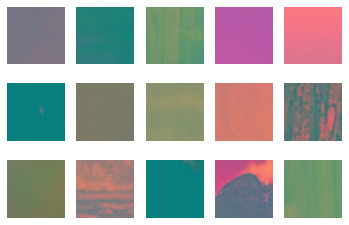

In [30]:
patches = transformTrainingSamples(train_path)

#size of training samples now
print(len(patches))

selected = np.random.choice(len(patches), 15)
plt.figure()
for i, ind in enumerate(selected):
  plt.subplot(3, 5, i+1)
  plt.imshow(patches[ind])
  plt.axis('off') 

Helper functons to create a LR image

In [77]:
def createLowResolutionImage(img):
  imgDims = img.shape
  lrImg = cv2.resize(img, (int(imgDims[1]/2), int(imgDims[0]/2)))
  return lrImg

def createHighResolutionImage(img):
  imgDims = img.shape
  hrImg = cv2.resize(img, (imgDims[1]*2, imgDims[0]*2), interpolation=cv2.INTER_CUBIC)
  return hrImg

LR : low resolution image after cubic interpolation
HR : Original image
SR : Reconstructed image from LR image

creating LR images from training images

In [13]:
os.chdir(train_path)
cnt = 0
lrImgs = []
hrImgs = []
for img_idx in os.listdir(train_path):
  if cnt < 5:
    print(img_idx)
    img_name = cv2.imread(img_idx)
    hrImgs.append(img_name)
    newImg = convertBGRToYCrCb(img_name)
    #low resolution image
    lrImg = createLowResolutionImage(newImg)
    #convert back to high resolution
    lrImg = createHighResolutionImage(lrImg)
    lrImgs.append(lrImg)
    cnt = cnt + 1
  else:
    break


376001.jpg
113009.jpg
198004.jpg
16052.jpg
153093.jpg


In [ ]:
for lr in lrImgs:
  lrRGB = convertYCrCbToRGB(lr)
  cv2_imshow(lrRGB)
  
for hr in hrImgs:
    cv2_imshow(hr)

Creating LR patches

In [79]:
lrPatch = []
for p_Idx in patches:
    #low resolution image
    lrImg = createLowResolutionImage(p_Idx)
    #convert back to high resolution
    lrImg = createHighResolutionImage(lrImg)
    lrPatch.append(lrImg)
print(len(lrPatch))

5170


Display some patches in their hr and lr versions

[1522 3412 4768 3026 3852 2373 3014  306 1282  284 1463 1938 2542 4059
 1145]
-----------High resolution images----------


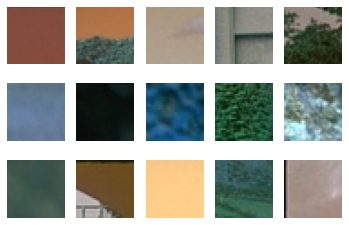

In [84]:
selected = np.random.choice(len(patches), 15)
plt.figure()
print('-----------High resolution images----------')
for i, ind in enumerate(selected):
  plt.subplot(3, 5, i+1)
  plt.imshow(convertYCrCbToRGB(patches[ind]))
  plt.axis('off') 

-----------Low resolution images----------


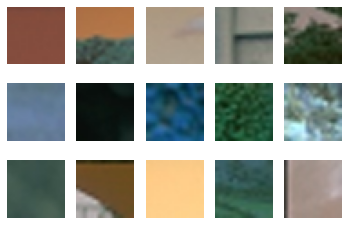

In [85]:
plt.figure()
print('-----------Low resolution images----------')
for i, ind in enumerate(selected):
  plt.subplot(3, 5, i+1)
  plt.imshow(convertYCrCbToRGB(lrPatch[ind]))
  plt.axis('off') 

Extract only Yth channel (0) from both training data and corresponding ground truth

-----------High resolution images----------


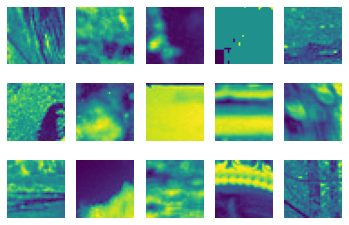

In [114]:
train = []
label = []
for t in patches:
  train.append(t[:, :, 0])

for l in lrPatch:
  label.append(l[:, :, 0])

selected = np.random.choice(len(train), 15)
plt.figure()
print('-----------High resolution images----------')
for i, ind in enumerate(selected):
  plt.subplot(3, 5, i+1)
  plt.imshow(train[ind])
  plt.axis('off') 

Split the patches into training and validation datasets

In [131]:
from sklearn.model_selection import train_test_split
trainArr = np.array(train)
trainLab = np.array(label)
print("shape of training input", trainArr.shape)
print("shape of label input", trainLab.shape)

train_ds, val_ds, train_lab, val_lab = train_test_split(trainArr, trainLab, test_size = 0.15, shuffle = True)

shape of training input (5170, 32, 32)
shape of label input (5170, 32, 32)


In [132]:
print("shape of training set", train_ds.shape)
print("shape of validation set", val_ds.shape)
print(type(train_ds))
print(type(val_ds))

shape of training set (4394, 32, 32)
shape of validation set (776, 32, 32)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Normalise the dataset

In [141]:
import glob
os.chdir(test_path)
print(os.getcwd())

files = glob.glob("*.jpg")
imgLst = []
for myFile in files:
  image = cv2.imread(myFile)
  image = np.array(image)
  imgLst.append(image)

testArr = np.array(imgLst)

/content/BSDS300/images/test


In [146]:
train_ds_norm = (train_ds / 255.0)
val_ds_norm = (val_ds / 255.0)
test_ds_norm = (testArr / 255.0)

## Define the model
Define the following architecture in tf.keras:
```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d (Conv2D)              (None, 32, 32, 128)       10496     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 1)         1601      
=================================================================
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________
```
* Use 9x9, 3x3 and 5x5 kernels with `relu`, `relu` and `linear` activations in `conv2d`, `conv2d_1` and `conv2d_2`, respectively.
* For optimizer use Adam, and MSE as loss function.
